# Orientation with IKPy


In this Notebook, we'll demonstrate inverse kinematics on orientation on a baxter robot:

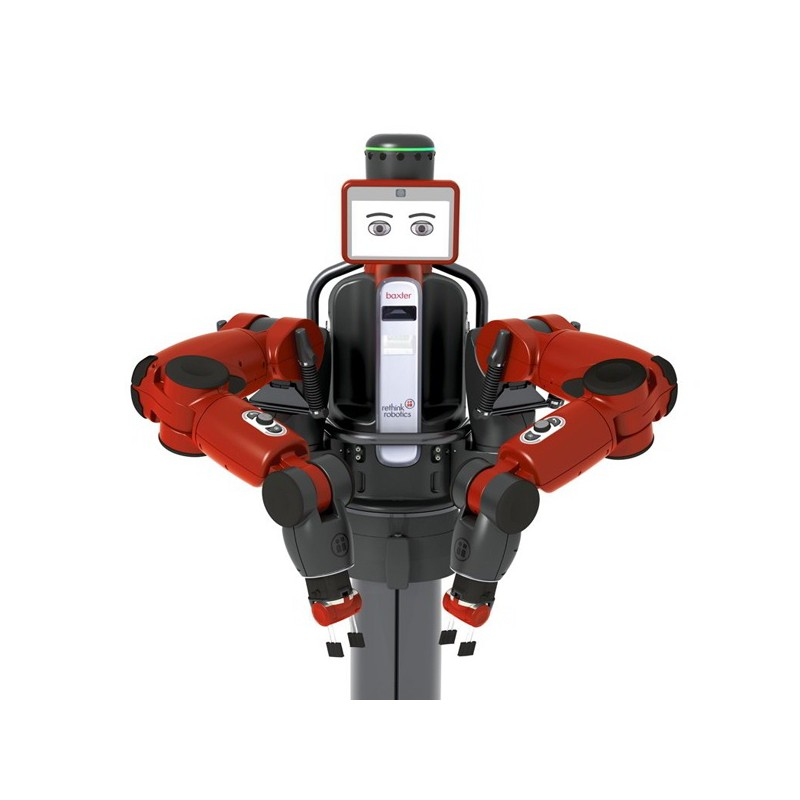

# Setup

In [1]:
# Some necessary imports
import numpy as np

from ikpy.chain import Chain
from ikpy.utils import plot

# Optional: support for 3D plotting in the NB
%matplotlib widget
# %matplotlib inline
# turn this off, if you don't need it

In [2]:
# First, let's import the baxter chains
baxter_left_arm_chain = Chain.from_json_file("../resources/baxter/baxter_left_arm.json")
baxter_right_arm_chain = Chain.from_json_file("../resources/baxter/baxter_right_arm.json")
baxter_pedestal_chain = Chain.from_json_file("../resources/baxter/baxter_pedestal.json")
baxter_head_chain = Chain.from_json_file("../resources/baxter/baxter_head.json")

/home/wslyen/.pyenv/versions/3.9.18/envs/webots_env/lib/python3.9/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint left_hand is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored
  warnings.warn("Joint {} is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored".format(joint.attrib["name"]))
/home/wslyen/.pyenv/versions/3.9.18/envs/webots_env/lib/python3.9/site-packages/ikpy/urdf/URDF.py:261: UserWarning: Joint right_hand is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored
  warnings.warn("Joint {} is of type: fixed, but has an 'axis' attribute defined. This is not in the URDF spec and thus this axis is ignored".format(joint.attrib["name"]))


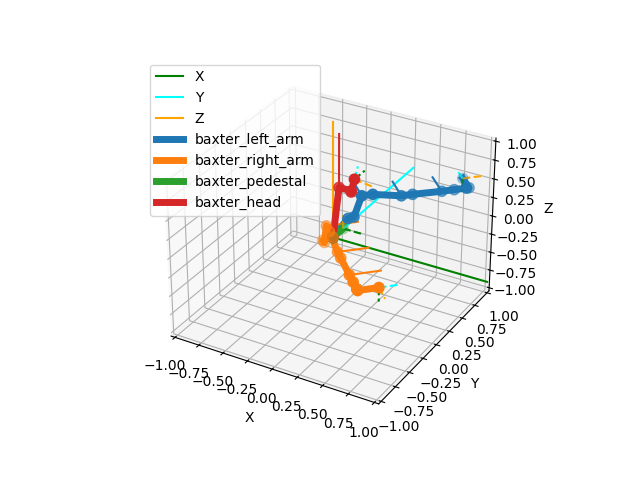

In [3]:
# Let's how it looks without kinematics first
from mpl_toolkits.mplot3d import Axes3D;
fig, ax = plot.init_3d_figure();
baxter_left_arm_chain.plot([0] * (len(baxter_left_arm_chain)), ax)
baxter_right_arm_chain.plot([0] * (len(baxter_right_arm_chain)), ax)
baxter_pedestal_chain.plot([0] * (2 + 2), ax)
baxter_head_chain.plot([0] * (4 + 2), ax)
ax.legend()

# Inverse Kinematics with Orientation 

[[ 1.76367581e-12 -4.86172331e-01  8.73862955e-01  1.00000000e-01]
 [-2.25257622e-12 -8.73862955e-01 -4.86172331e-01  5.00000000e-01]
 [ 1.00000000e+00 -1.11094377e-12 -2.63645012e-12 -1.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 1.76367581e-12 -2.25257622e-12  1.00000000e+00]
[ 0.1  0.5 -0.1]
--
Requested position: [0.1, 0.5, -0.1] vs Reached position: [ 0.1  0.5 -0.1]
Requested orientation on the X axis: [0, 0, 1] vs Reached orientation on the X axis: [ 1.76367581e-12 -2.25257622e-12  1.00000000e+00]


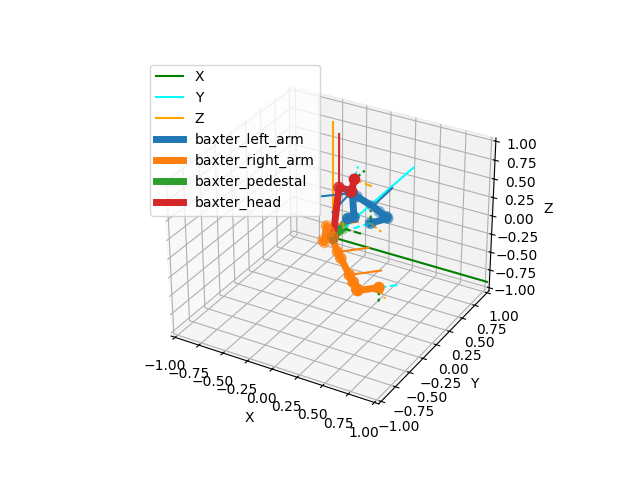

In [4]:
# Let's ask baxter to put his left arm at a target_position, with a target_orientation on the X axis.
# This means we want the X axis of his hand to follow the desired vector
target_orientation = [0, 0, 1]
target_position = [0.1, 0.5, -0.1]

# Compute the inverse kinematics with position
ik = baxter_left_arm_chain.inverse_kinematics(target_position, target_orientation, orientation_mode="X")

# Let's see what are the final positions and orientations of the robot
position = baxter_left_arm_chain.forward_kinematics(ik)[:3, 3]
orientation = baxter_left_arm_chain.forward_kinematics(ik)[:3, 0]

print(baxter_left_arm_chain.forward_kinematics(ik))
print(baxter_left_arm_chain.forward_kinematics(ik)[:3, 0])
print(baxter_left_arm_chain.forward_kinematics(ik)[:3, 3])
print("--")

# And compare them with was what required
print("Requested position: {} vs Reached position: {}".format(target_position, position))
print("Requested orientation on the X axis: {} vs Reached orientation on the X axis: {}".format(target_orientation, orientation))
# We see that the chain reached its position!

# Plot how it goes
fig, ax = plot.init_3d_figure();
baxter_left_arm_chain.plot(ik, ax)
baxter_right_arm_chain.plot([0] * (len(baxter_right_arm_chain)), ax)
baxter_pedestal_chain.plot([0] * (2 + 2), ax)
baxter_head_chain.plot([0] * (4 + 2), ax)
ax.legend()

In [5]:
print(baxter_left_arm_chain.forward_kinematics(ik))
print(baxter_left_arm_chain.forward_kinematics(ik)[:3, 0])
print(baxter_left_arm_chain.forward_kinematics(ik)[:3, 3])

[[ 1.76367581e-12 -4.86172331e-01  8.73862955e-01  1.00000000e-01]
 [-2.25257622e-12 -8.73862955e-01 -4.86172331e-01  5.00000000e-01]
 [ 1.00000000e+00 -1.11094377e-12 -2.63645012e-12 -1.00000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 1.76367581e-12 -2.25257622e-12  1.00000000e+00]
[ 0.1  0.5 -0.1]


# Mastering orientation

## Orientation vector and frame

Orientation in the example above IKPy is specified just by defining a **unit vector** we want the robot to align with.

In the example above, the orientation vector is simply the Z axis:

`target_orientation = [0, 0, 1]`

However, in 3D, orientation is not only one vector, but a full referential.
That's, in IKPy you have two options:

* Doing IK orientation on only one axis, as in the example above.
* Doing IK orientation on a full referential

Let's see the differences with a robot with a hand with a pointing finger:

* By doing orientation on only one axis, you only want your finger to point at a specific direction, but don't care at how the palm is
* By doing orientation on a full referential, you want your finger to point at a specific direction, but also want your palm to be at a specific orientation

## Orientation on a single axis

Orientation on a single axis is quite straightforward. You need to provide:

* A target unit vector, in the absolute referential
* The axis of your link you want to match that target unit vector

In the example below, we ask Baxter's arm's X axis (so relative to the link) to match the absolute Z axis

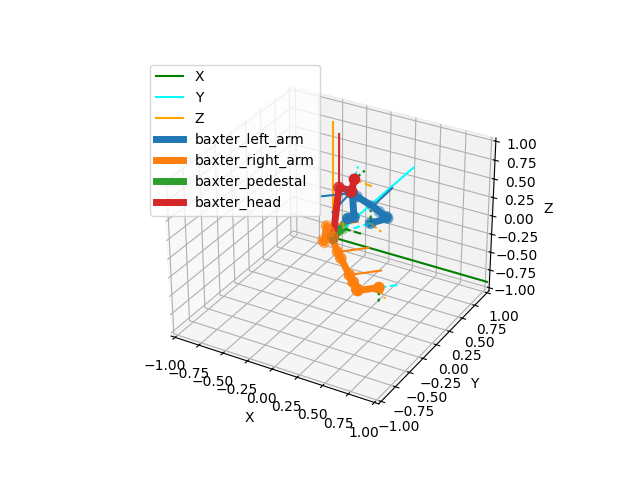

In [6]:
# Let's ask baxter to put his left arm's X axis to the absolute Z axis
orientation_axis = "X"
target_orientation = [0, 0, 1]

# Compute the inverse kinematics with position
ik = baxter_left_arm_chain.inverse_kinematics(
    target_position=[0.1, 0.5, -0.1],
    target_orientation=target_orientation,
    orientation_mode=orientation_axis)

# Plot how it goes
fig, ax = plot.init_3d_figure();
baxter_left_arm_chain.plot(ik, ax)
baxter_right_arm_chain.plot([0] * (len(baxter_right_arm_chain)), ax)
baxter_pedestal_chain.plot([0] * (2 + 2), ax)
baxter_head_chain.plot([0] * (4 + 2), ax)
ax.legend()


We see that the arm's X axis (in green) is aligned with the absolute referential's Z axis (in orange):
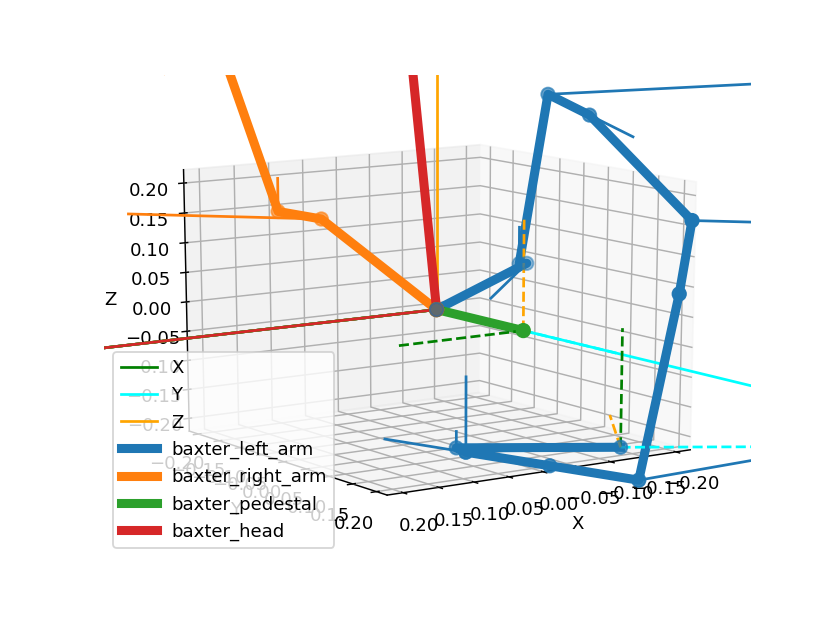

## Orientation on a full referential

In this setting, you just provide a frame to which the link's frame must align with, in the absolute referential.

This frame is a 3x3 orientation matrix (i.e. an orthogonal matrix, i.e. a matrix where all columns norm is one, and all columns are orthogonal)

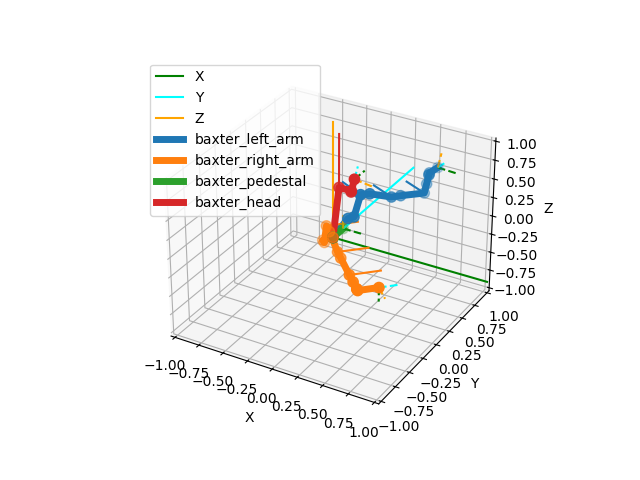

In [8]:
# Let's ask baxter to put his left arm as 
target_orientation = np.eye(3)

# Compute the inverse kinematics with position
ik = baxter_left_arm_chain.inverse_kinematics(
    target_position=[0.1, 0.5, -0.1],
    target_orientation=target_orientation,
    orientation_mode="all")

# Plot how it goes
fig, ax = plot.init_3d_figure();
baxter_left_arm_chain.plot(ik, ax)
baxter_right_arm_chain.plot([0] * (len(baxter_right_arm_chain)), ax)
baxter_pedestal_chain.plot([0] * (2 + 2), ax)
baxter_head_chain.plot([0] * (4 + 2), ax)
ax.legend()

In [9]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

We see that the arm frame's axes are all aligned with the absolute axes (in green/light blue/orange):
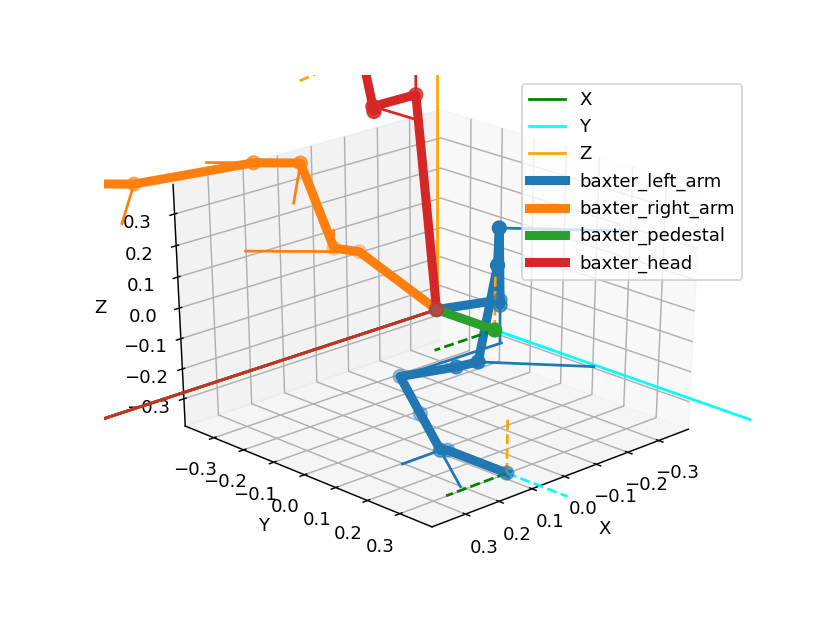

## Orientation and Position

When dealing with orientation, you may also want to set a target position.
IKPy can natively manage both orientation and position at the same time.

However, in some difficult cases, reaching a target position and orientation may be difficult, or even impossible.

In these cases, a solution is to cut this problem into two steps:

1. Reach the desired position
2. From this position, reach the desired orientation

This is what is done in the example below:

In [ ]:
# First begin to place the arm at the given position, without orientation
# So it will be easier for the robot to just move its hand to reach the desired orientation
ik = baxter_left_arm_chain.inverse_kinematics(target_position)
ik = baxter_left_arm_chain.inverse_kinematics(target_position, target_orientation, initial_position=ik, orientation_mode="X")